In [1]:
import numpy as np
import pandas as pd
import hippomaps as hm
from scipy.interpolate import griddata
from scipy.ndimage import binary_dilation
import nibabel as nib
import matplotlib.pyplot as plt
import copy
import raster_geometry as rg
import pygeodesic.geodesic as geodesic
import anndata as ad


/export03/data/opt/venv/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
# locate input data
source_dir = "../ABA_v3/"
hippunfold_dir = "../ABA_v3_hippunfold3/hippunfold/"
hemis = ['L']
labels = ['hipp']
den='0p5mm'

# here we will generate multiple depth-wise surfaces
depths = np.linspace(-0.25,1.25,num=25)
gm = np.where(np.logical_and(depths>=0,  depths <=1))[0]

# get expected number of vertices and their indices
nV,iV = hm.config.get_nVertices(labels,den)

In [ ]:
HumanGenes = pd.read_csv(f"../AlexNgo_microarray_gene_names.csv")
MouseGenes = pd.read_csv(f"Zhuang-ABCA-geneList.csv")
#NOTE these are actual orthologs
#https://github.com/oganm/homologene

In [15]:
ind_orthogenes = []
for i in range(len(MouseGenes)):
    mousegene = MouseGenes["gene_symbol"][i]
    cmd = f"/opt/R-3.6.3/bin/Rscript -e 'library(\"homologene\"); mouse2human(c(\"{mousegene}\"))'"
    b = !{cmd}
    humangene = b[1].split()[2]
    if humangene in HumanGenes["genes"].to_list():
        ind_orthogenes.append(i)

NameError: name 'MouseGenes' is not defined

In [ ]:
ind_orthogenes_human = []
for i in range(len(HumanGenes)):
    humangene = HumanGenes["genes"][i]
    cmd = f"/opt/R-3.6.3/bin/Rscript -e 'library(\"homologene\"); human2mouse(c(\"{humangene}\"))'"
    b = !{cmd}
    mousegene = b[1].split()[2]
    if mousegene in MouseGenes["gene_symbol"].to_list():
        ind_orthogenes_human.append(i)
np.save("ind_orthogenes_human.npy",ind_orthogenes)

IndexError: list index out of range

In [ ]:
len(ind_orthogenes)

743

In [ ]:
dat = np.load('checkpoint1.npz',allow_pickle=True)
allcoords = dat[dat.files[1]]
allclusters = dat[dat.files[2]]
allIDs = dat[dat.files[3]]

In [ ]:
alldat = []
for s in range(4):
    adata = ad.read(f'Zhuang-ABCA-{s+1}-log2.h5ad', backed='r')
    ind_dict = dict((k,i) for i,k in enumerate(adata.obs_names.to_numpy()))
    inter = set(ind_dict).intersection(allIDs[s])
    obsvs = [ ind_dict[x] for x in inter ]
    adata_array = adata.to_df().to_numpy()
    alldat.append(adata_array[obsvs,:][:,ind_orthogenes])

In [ ]:
alldat = np.vstack(alldat)
alldat.shape

(473645, 743)

In [ ]:
ref_orig = nib.load('../ABA_v3/sub-01/anat/sub-01_T1w.nii.gz')
shp = ref_orig.header.get_data_shape()
print(shp)
print(ref_orig.affine)
affine_notransl = copy.deepcopy(ref_orig.affine)
affine_notransl[:3,3] = 0 # remove offset

In [ ]:
# Create surfaces at various depths
dist_threshold = 2 #voxels
hipp_dat = np.ones([nV,len(depths), len(ind_orthogenes)])*np.nan
!mkdir -p "../ABA_v3_hippunfold3/hippunfold/sub-01/surf/depths"
for l,layer in enumerate(depths):
    cmd1 = f'wb_command -surface-cortex-layer '\
        f'../ABA_v3_hippunfold3/hippunfold/sub-01/surf/sub-01_hemi-L_space-T1w_den-0p5mm_label-hipp_inner.surf.gii '\
        f'../ABA_v3_hippunfold3/hippunfold/sub-01/surf/sub-01_hemi-L_space-T1w_den-0p5mm_label-hipp_outer.surf.gii '\
        f'{layer} '\
        f'../ABA_v3_hippunfold3/hippunfold/sub-01/surf/depths/sub-01_hemi-L_space-T1w_den-0p5mm_label-hipp_layer-{layer}.surf.gii'
    !{cmd1}
    gii = nib.load(f'../ABA_v3_hippunfold3/hippunfold/sub-01/surf/depths/sub-01_hemi-L_space-T1w_den-0p5mm_label-hipp_layer-{layer}.surf.gii')
    V = gii.darrays[1].data
    V = (np.linalg.inv(ref_orig.affine) @ np.concatenate((V.T,np.ones((1,len(V)))),axis=0)).T[:,:3]
    
    for v in range(len(V)):
        dist = np.sqrt((V[v,0]-allcoords[:,0])**2 + (V[v,1]-allcoords[:,1])**2 + (V[v,2]-allcoords[:,2])**2)
        hipp_dat[v,l,:] = np.mean(alldat[dist<dist_threshold,:],axis=0)

/export03/data/opt/venv/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


In [ ]:
np.savez('checkpoint3',hipp_dat, ind_orthogenes, allow_pickle=True)

In [3]:
dat = np.load('checkpoint3.npz',allow_pickle=True)
hipp_dat = dat[dat.files[1]]
ind_orthogenes = dat[dat.files[2]]

In [10]:
# interpolate nans & smooth a bit

hipp_inter = hipp_dat.reshape((-1,hipp_dat.shape[-1]))
gii = nib.load(f'../ABA_v3_hippunfold3/hippunfold/sub-01/surf/sub-01_hemi-L_space-T1w_den-0p5mm_label-hipp_midthickness.surf.gii')
V = gii.get_arrays_from_intent('NIFTI_INTENT_POINTSET')[0].data
F = gii.get_arrays_from_intent('NIFTI_INTENT_TRIANGLE')[0].data

# replicate connectivity between layers
Fnew = copy.deepcopy(F)
for l in range(len(depths)-1):
    Fnew = np.vstack((Fnew,F+len(V)+1))
# connect columns
F2 = np.zeros((0,3)).astype(int)
for v in range(len(V)):
    F2 = np.vstack((F2, np.array([v,v+len(V)+1,v]).astype(int)))
F3 = np.zeros((0,3)).astype(int)
for l in range(len(depths)-1):
    F3 = np.vstack((F3, F2+len(V)*(l)))
Fnew = np.vstack((Fnew,F3))
Fnew[Fnew>(hipp_inter.shape[0]-1)] = 0

# new smooth by nanmean over connected vertices
hipp_inter = hm.utils.surfdat_smooth(Fnew,hipp_inter,iters=3, cores=24)
hipp_inter

In [13]:
hipp_inter = hipp_inter.reshape((len(V),len(depths),hipp_dat.shape[2]))

5914280

In [ ]:
hippflat = np.nanmean(hipp_dat[:,gm,:],axis=1)

image = nib.gifti.GiftiImage()
data_array = nib.gifti.GiftiDataArray(data=hippflat.astype(np.float32))
image.add_gifti_data_array(data_array)
nib.save(image,'hipp_flat.func.gii')
cmd = "wb_command -metric-smoothing "\
    "../ABA_v3_hippunfold3/hippunfold/sub-01/surf/sub-01_hemi-L_space-T1w_den-0p5mm_label-hipp_midthickness.surf.gii "\
    "hipp_flat.func.gii 1 hipp_flat_smooth.func.gii"
out = !{cmd}

gii = nib.load('hipp_flat_smooth.func.gii')
hipp_flat_smooth = np.zeros((gii.darrays[0].data.shape[0], len(gii.darrays)))
for k in range(len(gii.darrays)):
    hipp_flat_smooth[:,k] = gii.darrays[k].data
hipp_flat_smooth.shape

(7262, 743)

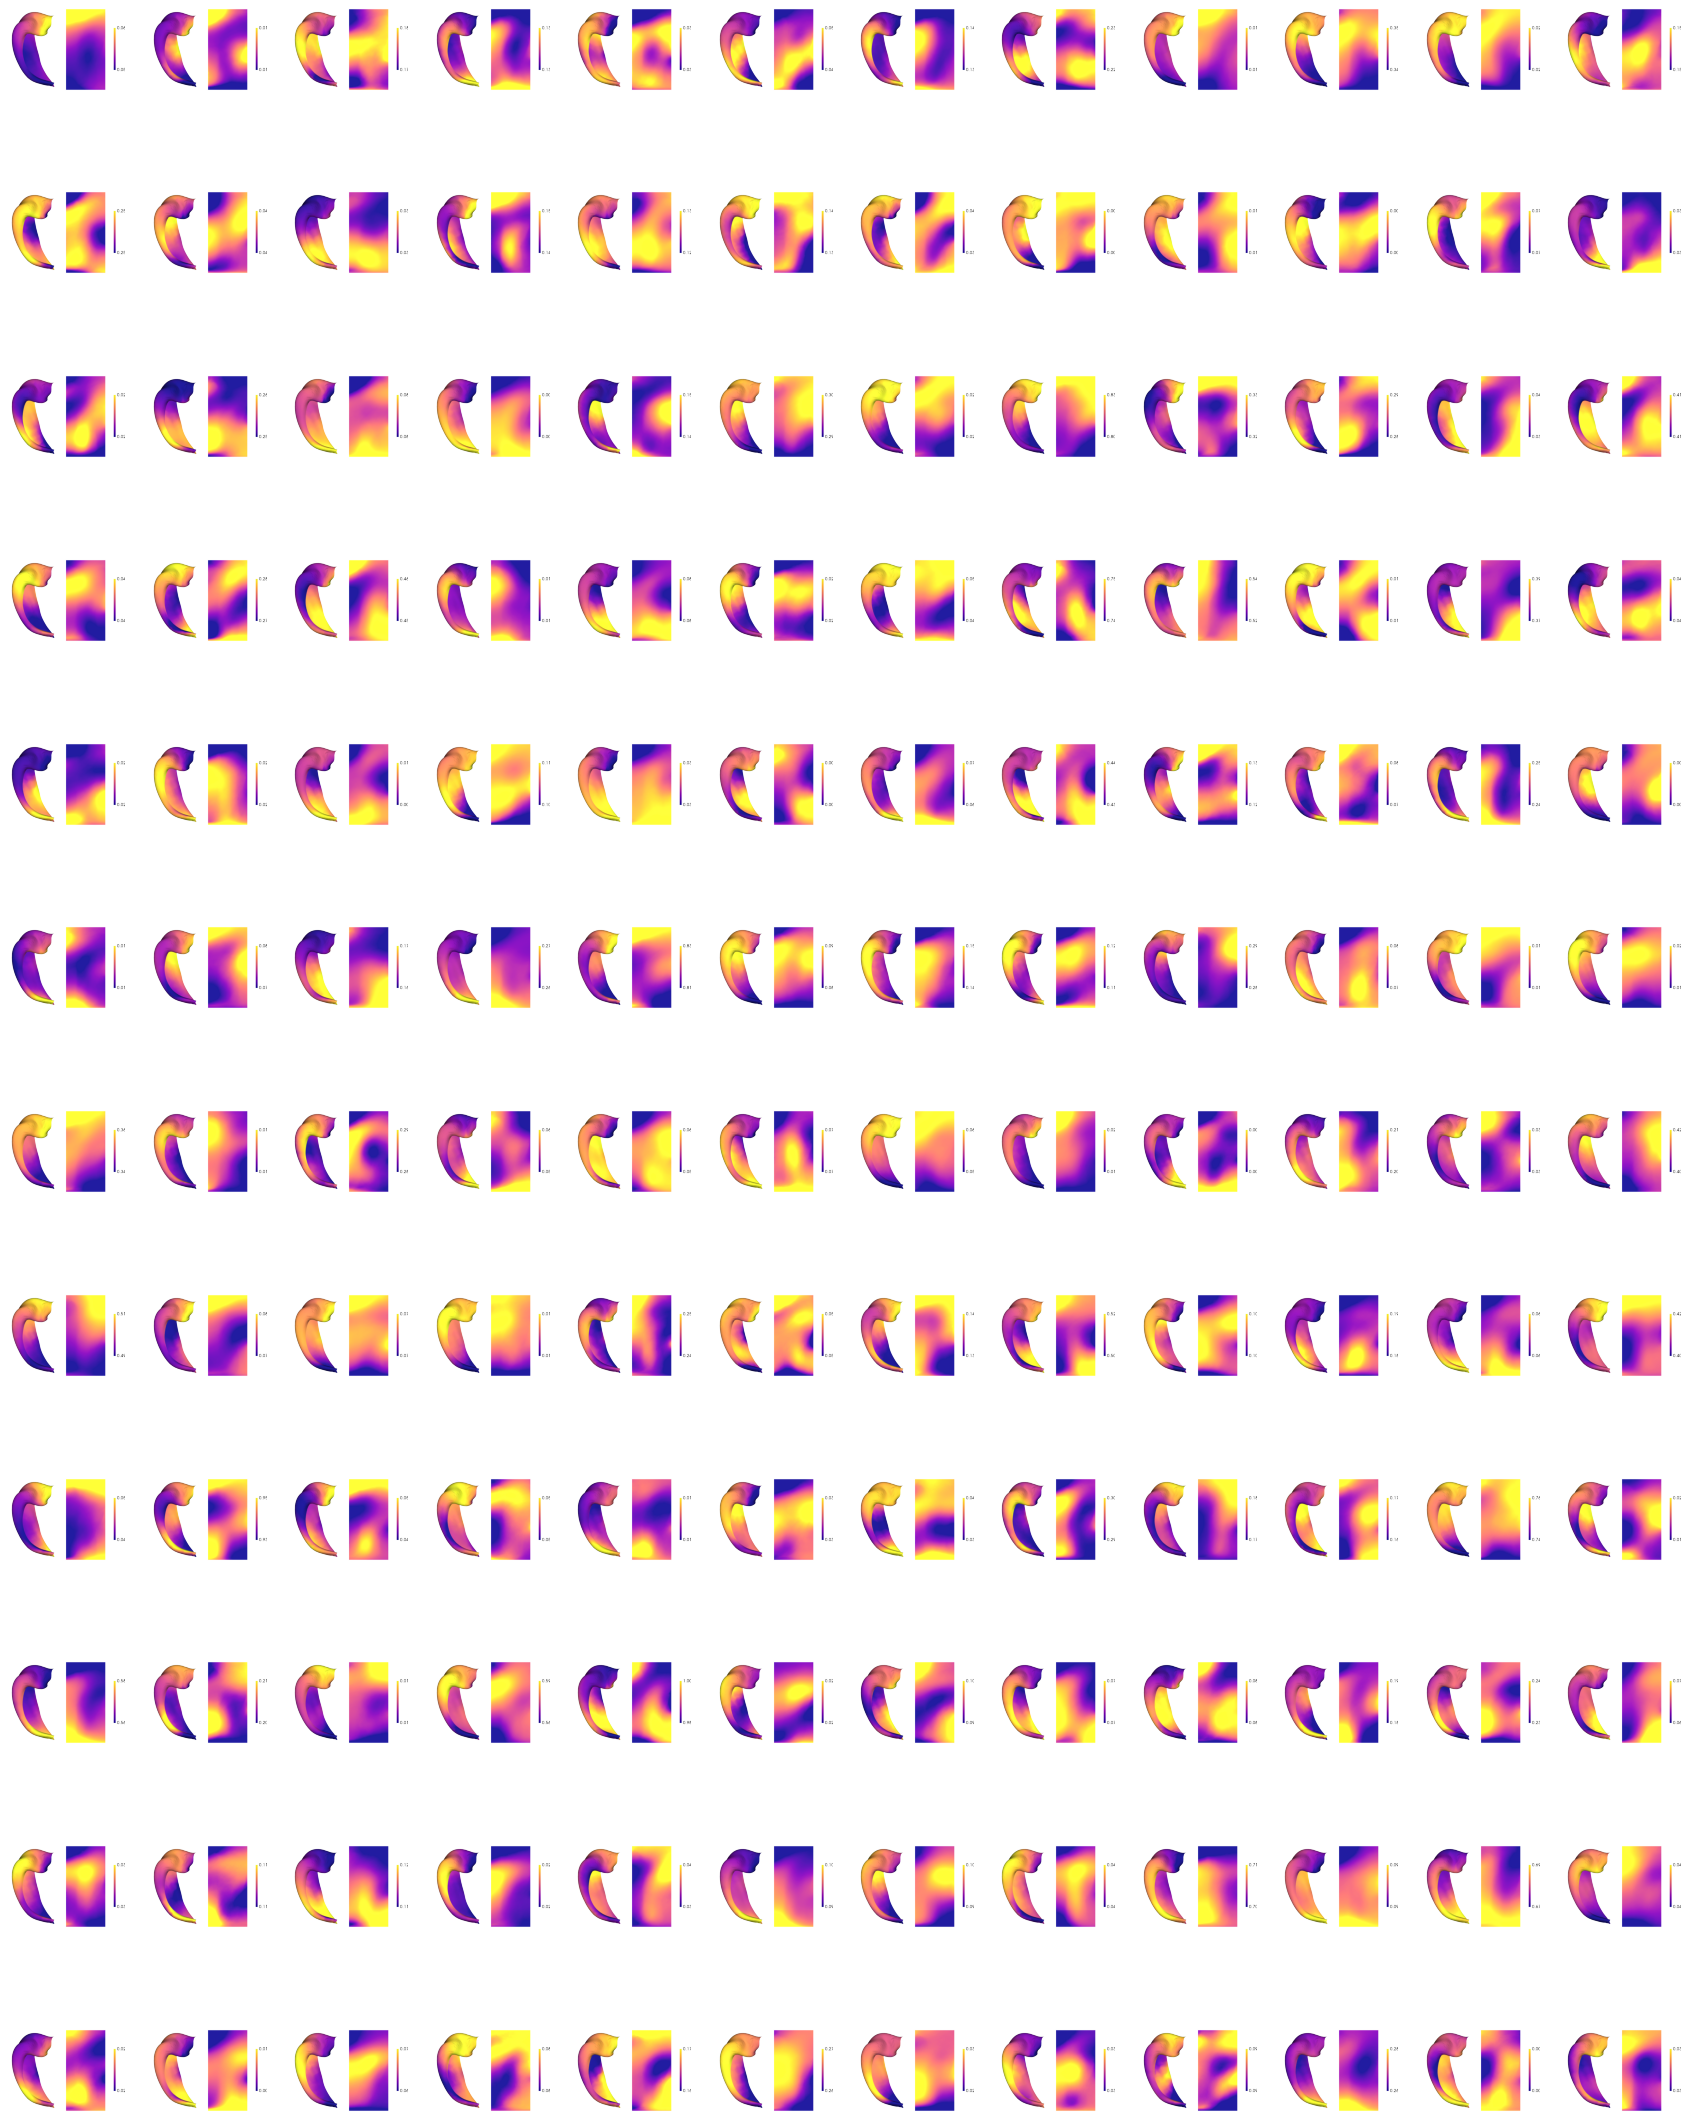

In [ ]:
fig, ax = plt.subplots(nrows=12, ncols=12, figsize=(30,40))
col = plt.cm.jet(np.linspace(0,1,5))    

for i in range(12*12):
    plotdat = hipp_flat_smooth[:,i]
    hm.plotting.surfplot_canonical_foldunfold(plotdat, labels=labels, hemis=['L'], unfoldAPrescale=True, den=den, cmap='plasma', color_bar='right', share='row',  tighten_cwindow=True, embed_nb=True, screenshot=True, filename='tmp.png')
    f = plt.imread(f'tmp.png')
    ax[int(i/12),i%12].imshow(f)
    ax[int(i/12),i%12].set_axis_off()
    ax[int(i/12),i%12].set_anchor("NW")

## MPCs

In [ ]:
from brainspace.gradient import GradientMaps
from hippomaps.build_mpc import build_mpc

In [ ]:
#mMP = hipp_flat_smooth
mMP = hipp_dat[:,gm,:].reshape((hipp_dat.shape[0],-1))
mMP[np.isnan(mMP)] = 0 #set nans to zero
mMPC, I, problemNodes = build_mpc(mMP.T) # compute mMPC

/export03/data/opt/hippomaps/hippomaps/build_mpc.py:145: RuntimeWarning: divide by zero encountered in true_divide
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )


(-0.5, 7261.5, 7261.5, -0.5)

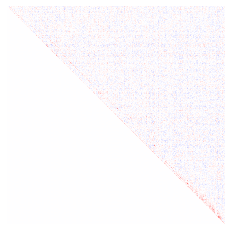

In [ ]:
# plot the mMPC to get a sense of similarity between vertices.
plt.imshow(mMPC, vmin=-.1, vmax=.1, cmap='bwr')
plt.axis('off')

In [ ]:
mGM = GradientMaps(n_components=5, )
mGM.fit(mMPC,)

/export03/data/opt/venv/lib/python3.8/site-packages/brainspace/gradient/embedding.py:70: UserWarning: Affinity is not symmetric. Making symmetric.
  warnings.warn('Affinity is not symmetric. Making symmetric.')


GradientMaps(n_components=5)

/export03/data/opt/venv/lib/python3.8/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


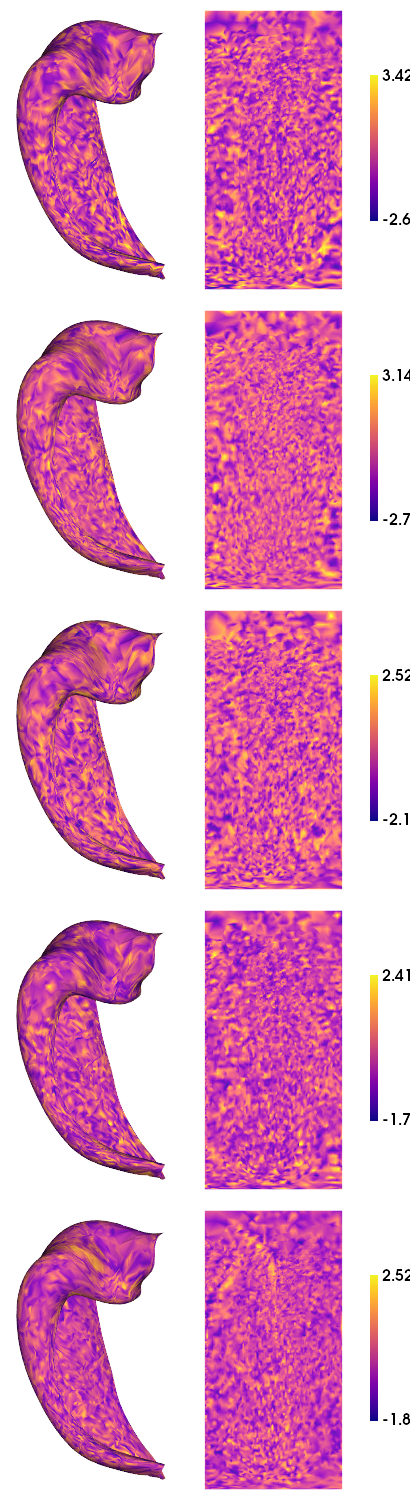

In [ ]:
hm.plotting.surfplot_canonical_foldunfold(mGM.gradients_, labels=labels, hemis=['L'], unfoldAPrescale=True, den=den, cmap='plasma', color_bar='right', share='row',  tighten_cwindow=False, embed_nb=True)

In [ ]:
mGM.gradients_.shape

(26, 5)